In [4]:
# tweepy version 3.7.0~3.10.0 사이에서만 konlpy가 실행된다. version확인 후 해당 version이 아니면 아래 코드를 실행해 재설치한다.
# 재설치했다면 kernel restart한다
#!pip install tweepy==3.10.0

In [5]:
import tweepy
tweepy.__version__

'4.10.0'

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

KoNPLy 설치: https://liveyourit.tistory.com/56

# 데이터 다운로드 및 확인

In [7]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1063cfc70>)

In [8]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [9]:
len(train_data)

150000

In [10]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [12]:
len(test_data)

50000

In [13]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


# train data preprocessing

In [15]:
# 중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [16]:
# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
len(train_data)

146183

<AxesSubplot:>

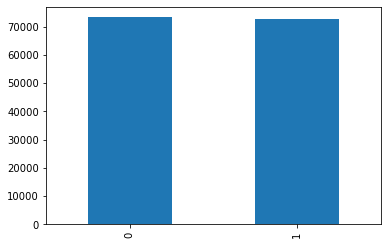

In [17]:
train_data['label'].value_counts().plot(kind = 'bar')

In [18]:
# null값 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [19]:
# null값 제거
train_data = train_data.dropna(how = 'any')
train_data.isnull().values.any()

False

In [20]:
len(train_data)

146182

### 특수문자 제거

In [21]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [22]:
# 리뷰 데이터기 비었다면 null로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [23]:
train_data.loc[train_data.document.isnull()].head()

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [24]:
# null데이터 제거
train_data = train_data.dropna(how = 'any')
len(train_data)

145393

# test data preprocessing

In [25]:
# 중복 확인
test_data['document'].nunique(), test_data['label'].nunique()

(49157, 2)

In [26]:
# 중복 제거
test_data.drop_duplicates(subset=['document'], inplace=True)
len(test_data)

49158

<AxesSubplot:>

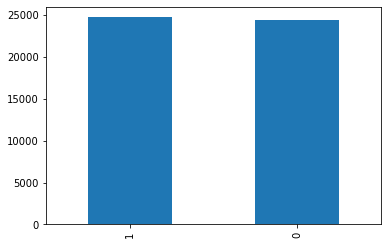

In [27]:
test_data['label'].value_counts().plot(kind = 'bar')

In [28]:
# null값 확인
test_data.loc[test_data.document.isnull()]

,id,document,label
5746,402110,NaN,1


In [29]:
# null값 제거
test_data = test_data.dropna(how = 'any')
test_data.isnull().values.any()

False

In [30]:
len(test_data)

49157

### 특수문자 제거

In [31]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [32]:
# 리뷰 데이터기 비었다면 null로 변경
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
print(test_data.isnull().sum())

id            0
document    305
label         0
dtype: int64


In [33]:
test_data.loc[test_data.document.isnull()].head()

,id,document,label
1,9274899,NaN,0
116,6910486,NaN,1
254,4976468,NaN,0
468,7517102,NaN,0
504,2096424,NaN,0


In [34]:
# null데이터 제거
test_data = test_data.dropna(how = 'any')
len(test_data)

48852

# tokenize

In [35]:
# 불용어 정의. 더 추가해도 상관 없음
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [36]:
okt = Okt()

okt 에러 시 참고: https://byeon-sg.tistory.com/entry/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-konlpy-%EC%84%A4%EC%B9%98-%EC%98%A4%EB%A5%98-okt%EC%97%90%EB%9F%AC-already-loaded-in-another-classloader-SystemErro-1

In [37]:
# train data 토큰화
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [03:17<00:00, 736.45it/s]


In [38]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [39]:
# test data 토큰화
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [01:10<00:00, 694.69it/s]


In [40]:
print(X_test[:3])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


# 정수 인코딩

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [42]:
#print(tokenizer.word_index)

In [43]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [44]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [45]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [46]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [47]:
# 제거한 결과를 tokenizer로 넘김
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [48]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [49]:
# 학습을 위한 label 데이터를 따로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [50]:
# 위에서 등장빈도 2 이하 단어로만 이루어져 비어버린 되어버린 샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [51]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train), len(y_train))

145162 145162


# Padding

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


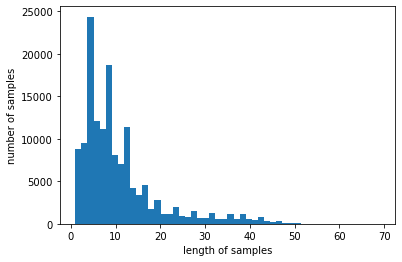

In [52]:
# 샘플 길이를 동일하게 맞춰주는 작업을 위한 전체 데이터 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [53]:
# max_len이하인 데이터의 비율 확인 함수
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [54]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [55]:
# 전체 샘플 길이 max_len으로 맞춤
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# Sentimental Analysis using LSTM

In [56]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

In [57]:
embedding_dim = 100
hidden_units = 128

In [58]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-05 22:06:08.748963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-05 22:06:08.749249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [60]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1941600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,058,977
Trainable params: 2,058,977
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/50


2022-06-05 22:06:09.111242: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 22:06:09.914829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:06:10.088349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   3/1815 [..............................] - ETA: 52s - loss: 0.6922 - acc: 0.5208  

2022-06-05 22:06:10.224569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1815/1815 [==============================] - ETA: 0s - loss: 0.3889 - acc: 0.8226

2022-06-05 22:06:49.503367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:06:49.562322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.84328, saving model to best_model.h5
1815/1815 [==============================] - 44s 24ms/step - loss: 0.3889 - acc: 0.8226 - val_loss: 0.3520 - val_acc: 0.8433
Epoch 2/50
1815/1815 [==============================] - ETA: 0s - loss: 0.3259 - acc: 0.8588
Epoch 2: val_acc improved from 0.84328 to 0.85516, saving model to best_model.h5
1815/1815 [==============================] - 43s 23ms/step - loss: 0.3259 - acc: 0.8588 - val_loss: 0.3333 - val_acc: 0.8552
Epoch 3/50
1814/1815 [============================>.] - ETA: 0s - loss: 0.3010 - acc: 0.8724
Epoch 3: val_acc improved from 0.85516 to 0.85541, saving model to best_model.h5
1815/1815 [==============================] - 44s 24ms/step - loss: 0.3010 - acc: 0.8724 - val_loss: 0.3368 - val_acc: 0.8554
Epoch 4/50
1815/1815 [==============================] - ETA: 0s - loss: 0.2820 - acc: 0.8824
Epoch 4: val_acc improved from 0.85541 to 0.86171, saving model to best_model.h5
1815/1815 [=============

In [63]:
# 모델 저장 (weight저장X, 동일 모델로 다시 학습 가능)
model.save('best_model.h5')

# 모델 평가

In [64]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 13s 9ms/step - loss: 0.3579 - acc: 0.8525
정확도 : 0.8525


In [65]:
loss, acc = model.evaluate(X_train, y_train, verbose=2)

4537/4537 - 33s - loss: 0.2246 - acc: 0.9118 - 33s/epoch - 7ms/step


FileNotFoundError: [Errno 2] No such file or directory: './plot_img/LSTM_loss_1112.png'

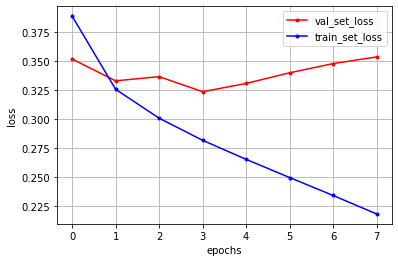

In [66]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.savefig('LSTM_loss_1112.png')

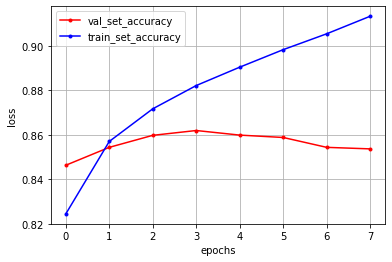

In [ ]:
y_vloss = history.history['val_acc']
y_loss = history.history['acc']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_accuracy')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.savefig('./plot_img/LSTM_acc_1112.png')

# 리뷰 예측

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict("정말 재미있어요")

97.87% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('쓰레기 같은 영화...')

99.54% 확률로 부정 리뷰입니다.



참고: https://wikidocs.net/44249

### 영화평론가 리뷰

In [ ]:
# 영화 <이터널스> 배동미 평론가, 평점 7점
sentiment_predict('올림피아는 없다. 창배하고 푸른 점뿐')

53.25% 확률로 부정 리뷰입니다.



In [ ]:
# 영화 <이터널스> 이용철 평론가, 평점 6점
sentiment_predict('사랑의 반역자들이라 환영하긴 한다만, 만족스럽지는 않다')

91.95% 확률로 부정 리뷰입니다.



In [ ]:
# 영화 <듄> 이용철 평론가, 평점 8점
sentiment_predict('아이맥스의 성과는 <그래비티> 이후 최고다, 린치의 <듄>은 이제 잊어도 되겠다')

99.47% 확률로 긍정 리뷰입니다.



In [ ]:
# 영화 <듄> 심규한 평론가, 평점 8점
sentiment_predict('아름답고 경이롭다. 시네마란 이런 것이라고 증명하듯 드니 빌뇌브가 펼쳐낸 이미지의 세계는 관객의 눈과 귀를 완전하게 지배한다. 방대한 원작의 내용을 빼곡하게 채우는 대신 의도적으로 보일 만큼 느슨하게 흘러가는 이야기의 밀도는 탁월한 선택이 됐다. 과감한 클로즈업으로 확보된 인물의 감정, 상상의 영역을 현실의 지점으로 끌어온 듯한 정교한 스펙터클은 내러티브 이상의 충분한 몰입을 선사한다.')

99.50% 확률로 긍정 리뷰입니다.



In [ ]:
# 영화 <베놈 2: 렛 데어 비 카니지> 정시우 평론가, 평점 5점 
sentiment_predict('다소 우울한 평가를 받은 <베놈>의 속편이 나온다길래, 소니가 절치부심하고 판을 새롭게 뒤집나 했더니, 에라이……. 1편의 단점을 계승한 가운데, B급 코드와 러브스토리를 조금 더 뿌렸을 뿐 발전적 면모는 쉽게 발견되지 않는다. B급 유머와 유치함은 염연히 다른데, 유치함을 B급이라 우기는 듯한 순간도 여럿 포착되는 게 흠. 어쩌려고 베놈 캐릭터를 더 귀엽게(?) 승화시켰는지 의문인데, 쿠키만큼은 참 잘 구웠다.')

88.04% 확률로 부정 리뷰입니다.



In [ ]:
# 영화 베놈 2: 렛 데어 비 카니지> 박평식 평론가, 평점 4점
sentiment_predict('좋은 건 쿠키영상, 더 좋은 건 러닝타임')

99.53% 확률로 부정 리뷰입니다.



# 네이버 영화 리뷰 크롤링 데이터 가져오기

In [ ]:
movie = pd.read_csv('./movie/comedy/naver_movie_review_1111_Ted.csv')
movie.head()

,title,link,score,review
0,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,아 정말ㅋㅋㅋㅋㅋ 이런 유머 너무 좋아요
1,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,죤나게재밌다.어린시절의 순수함을 가지고 성인이 ㅤㄷㅙㄴ사람이라면 무조건 추천
2,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,진짜웃김ㅋㅋㅋ곰인형이 주인공이랑 싸울때 바지벗기고 회초리로 엉덩이 때리는부분 짱 웃...
3,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,인간과 봉제곰의 격렬한 액션씬이 가장 인상에 남는 작품.
4,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,진짜ㅋㅋㅋㅋ굿


In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1630 non-null   object
 1   link    1630 non-null   object
 2   score   1630 non-null   int64 
 3   review  1628 non-null   object
dtypes: int64(1), object(3)
memory usage: 51.1+ KB


## null 데이터 제거

In [ ]:
movie.isnull().values.any()

True

In [ ]:
movie = movie.dropna(how = 'any')
movie.isnull().values.any()

False

In [ ]:
len(movie)

1628

## 특수문자 제거

In [ ]:
movie['review'] = movie['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
movie.head()

,title,link,score,review
0,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,아 정말ㅋㅋㅋㅋㅋ 이런 유머 너무 좋아요
1,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,죤나게재밌다어린시절의 순수함을 가지고 성인이 ㄷㅙㄴ사람이라면 무조건 추천
2,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,진짜웃김ㅋㅋㅋ곰인형이 주인공이랑 싸울때 바지벗기고 회초리로 엉덩이 때리는부분 짱 웃...
3,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,인간과 봉제곰의 격렬한 액션씬이 가장 인상에 남는 작품
4,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,진짜ㅋㅋㅋㅋ굿


In [ ]:
# 리뷰 데이터기 비었다면 null로 변경
movie['review'] = movie['review'].str.replace('^ +', "")
movie['review'].replace('', np.nan, inplace=True)
print(movie.isnull().sum())

title     0
link      0
score     0
review    9
dtype: int64


In [ ]:
# null데이터 제거
movie = movie.dropna(how = 'any')
len(movie)

1619

## 해당 리뷰가 긍정일 확률 구하기

In [ ]:
predicted = []

def sentiment_pred(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    predicted.append(round(score, 5))

In [ ]:
for a in movie['review']:
    sentiment_pred(a)

In [ ]:
print(predicted)

[0.99508, 0.99257, 0.98767, 0.99632, 0.99201, 0.35568, 0.9971, 0.9213, 0.91364, 0.9917, 0.99633, 0.9909, 0.31279, 0.99148, 0.93718, 0.98947, 0.61357, 0.88511, 0.96334, 0.9686, 0.17205, 0.21154, 0.7805, 0.97586, 0.82428, 0.91134, 0.00132, 0.70736, 0.00093, 0.33908, 0.99783, 0.84197, 0.1051, 0.06024, 0.88243, 0.96025, 0.54992, 0.30215, 0.65163, 0.83402, 0.97283, 0.70308, 0.89605, 0.99871, 0.93691, 0.17052, 0.99909, 0.95773, 0.9741, 0.94075, 0.01688, 0.99444, 0.97404, 0.96205, 0.91875, 0.9123, 0.98797, 0.12579, 0.88996, 0.68266, 0.97281, 0.99324, 0.00563, 0.05508, 0.99513, 0.04626, 0.99687, 0.83571, 0.98669, 0.92678, 0.85218, 0.36276, 0.56653, 0.61746, 0.18691, 0.97681, 0.0298, 0.99648, 0.84462, 0.77524, 0.99629, 0.99778, 0.20225, 0.114, 0.81335, 0.98352, 0.32173, 0.9966, 0.17571, 0.98161, 0.25389, 0.99704, 0.40546, 0.99399, 0.07812, 0.00881, 0.3987, 0.00581, 0.63793, 0.00043, 0.05044, 0.99149, 0.97565, 0.53173, 0.15194, 0.97233, 0.99249, 0.00598, 0.29543, 0.0201, 0.74195, 0.73297, 0.0016

## score과 긍정확률을 추가한 dataFrame생성

In [ ]:
pred = pd.DataFrame(predicted)
pred.head()

,0
0,0.99508
1,0.99257
2,0.98767
3,0.99632
4,0.99201


In [ ]:
len(movie)

1619

In [ ]:
len(pred)

1619

In [ ]:
movie_sentiment = movie

In [ ]:
movie_sentiment.loc[:,'sentiment'] = predicted
movie_sentiment

,title,link,score,review,sentiment
0,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,아 정말ㅋㅋㅋㅋㅋ 이런 유머 너무 좋아요,0.99508
1,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,죤나게재밌다어린시절의 순수함을 가지고 성인이 ㄷㅙㄴ사람이라면 무조건 추천,0.99257
2,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,진짜웃김ㅋㅋㅋ곰인형이 주인공이랑 싸울때 바지벗기고 회초리로 엉덩이 때리는부분 짱 웃...,0.98767
3,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,인간과 봉제곰의 격렬한 액션씬이 가장 인상에 남는 작품,0.99632
4,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,진짜ㅋㅋㅋㅋ굿,0.99201
...,...,...,...,...,...
1625,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,1,장르불명기영화,0.00964
1626,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,10,ㅋㅋㅋㅋㅋ곰돌이가 즈질인데 너무 귀엽게 생겼음 ㅋㅋ 병맛느낌 나게 재미있음 ㅋㅋㅋ,0.88904
1627,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,1,재밌어보여서 봤는데 보고나니 왜 평점이 낮은지 알겠다 한번도 안웃었다 감동도 재미도...,0.00083
1628,19곰 테드,https://movie.naver.com/movie/bi/mi/pointWrite...,1,어른들을 위한 동화,0.89621


In [ ]:
movie_sentiment.to_csv('movie_sentiment_1111_Ted.csv', encoding='euckr', index=False)